In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

# Load the dataset
df = pd.read_csv(url, names=column_names, na_values="?")

# Drop rows with missing values
df.dropna(inplace=True)

# Convert categorical columns to numeric
df = df.astype(float)

# Convert target to binary classification (1 if heart disease, 0 if not)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Display dataset info
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
# Split features and target
X = df.drop(columns=["target"])
y = df["target"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
 #hyperparameters
learning_rate = 0.1
iterations = 1000
input_size = X_train.shape[1]  # 3 input features (including bias column)
hidden_size = 6  # 3 neurons in the hidden layer

#more hidden layers
hidden_size2 = 5
hidden_size3 = 4

output_size = 1  # 1 output (since it's a binary classification problem)

# Initialize weights (including bias as part of the weights)
np.random.seed(0)
W1 = np.random.randn(input_size, hidden_size) #* 0.01  # weights for input to hidden layer (including bias term)
W2 = np.random.randn(hidden_size, hidden_size2)  # weights for hidden to hidden layer (including bias term)

#more weights
W3 = np.random.randn(hidden_size2, hidden_size3) #weights for hidden to hidden layer
W4 = np.random.randn(hidden_size3, output_size) #weights for hidden to output layer


In [ ]:
#activation functions
def relu(x):
  return np.maximum(0,x)

def sigmoid(x):
  return 1/(1+np.exp(-x))

#loss function
def bce_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#accuracy
#def acc_score(y_true, y_pred):
#    return np.mean(y_true == y_pred)

In [ ]:
#forward propagation
def forward(X):
    z1 = np.dot(X, W1)  # input to hidden layer (X includes bias column)
    a1 = relu(z1)  # activation function (ReLU)
    #hidden to hidden layer
    z2 = np.dot(a1, W2)  # hidden to hidden layer
    a2 = relu(z2)

    z3 = np.dot(a2, W3)  # hidden to hidden layer
    a3 = relu(z3)

    z4 = np.dot(a3, W4)  # hidden to output layer
    output = sigmoid(z4)  # output layer (sigmoid activation)
    return output, (a1, a2, a3)

# back propagation
def backward(X, y_true, output, activations):
    global W1, W2, W3, W4
    a1, a2, a3 = activations

    # Calculate the loss derivative (Mean Squared Error)
    m = y_true.shape[0]
    y_true = y_true.to_numpy().reshape(-1, 1)  # reshape y_true to match output shape
    d_output = (output - y_true) / m  # derivative of loss wrt output

    dw4 = np.dot(a3.T, d_output)  # gradient for W4
    d_a3 = np.dot(d_output, W4.T)  # derivative of loss wrt a3
    d_z3 = d_a3 * (a3 > 0)  # derivative of ReLU activation

    dw3 = np.dot(a2.T, d_z3)  # gradient for W3
    d_a2 = np.dot(d_z3, W3.T)  # derivative of loss wrt a2
    d_z2 = d_a2

    # Derivatives for W2
    dW2 = np.dot(a1.T, d_z2)  # gradient for W2
    # Backpropagate to the hidden layer
    d_a1 = np.dot(d_z2, W2.T)  # derivative of loss wrt a1
    d_z1 = d_a1 * (a1 > 0)  # derivative of ReLU activation

    # Derivatives for W1
    dW1 = np.dot(X.T, d_z1)  # gradient for W1

    # Update weights
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    W3 -= learning_rate * dw3
    W4 -= learning_rate * dw4

In [ ]:
trainloss = []
trainaccc = []
#Training the MLP
for i in range(iterations):
    output, activations = forward(X_train)
    backward(X_train, y_train, output, activations)
    if i % 500 == 0:
      loss = bce_loss(y_train.to_numpy(), output)

      #calculate accuracy
      y_pred = (output > 0.5).astype(int)
      acc = accuracy_score(y_train.to_numpy(), y_pred)

      trainloss.append(loss)
      trainaccc.append(acc)

      print(f"Iteration {i}: BCE Loss = {loss:.4f}, Accuracy = {acc:.4f}")

Iteration 0: BCE Loss = 5.3284, Accuracy = 0.4726
Iteration 500: BCE Loss = 1.5289, Accuracy = 0.8650


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


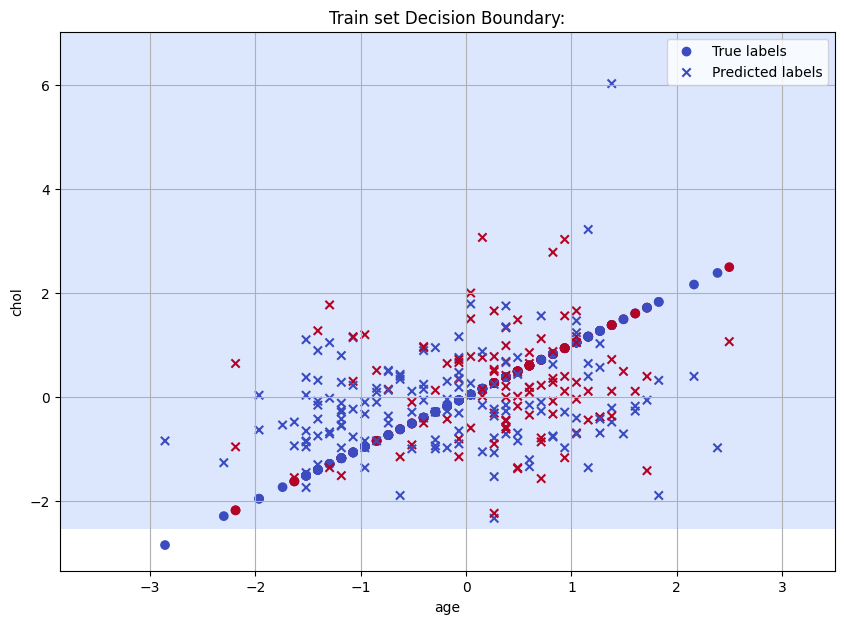

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


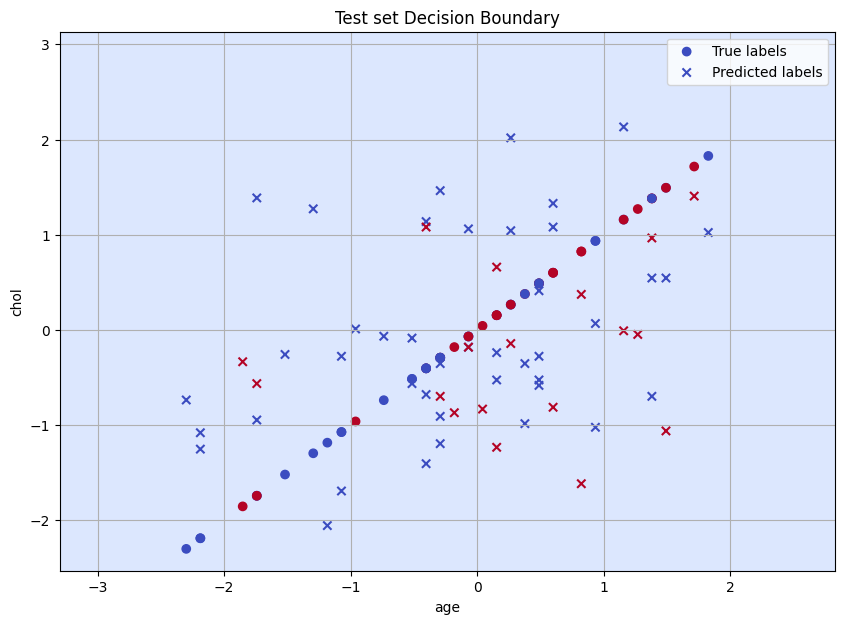

Train Accuracy: 0.8565400843881856
Test Accuracy: 0.9


In [ ]:
#prediction after training
predictions = forward(X_train)[0]
predictions = (predictions > 0.5).astype(int) #convert to binary

test_pred = forward(X_test)[0]
test_predictions = (test_pred > 0.5).astype(int)

X_np = X.values
feature1 = 0
feature2 = 4
# Create a mesh grid for plotting decision boundaries
'''x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict for each point in the mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
#grid_points_bias = np.c_[np.ones((grid_points.shape[0], 1)), grid_points]  # ✅ Fixed
#predictions_grid, _ = forward(grid_points_bias)
grid_input = np.zeros((grid_points.shape[0], X_train.shape[1]))
grid_input[:, feature1] = grid_points[:, 0]
grid_input[:, feature2] = grid_points[:, 1]
grid_input = scaler.transform(grid_input)

predictions_grid, _ = forward(grid_input)
predictions_grid = (predictions_grid > 0.5).astype(int)
'''
def plot_decision_boundary(X_raw, y_true, predictions, title, feature1, feature2, filename=None):
    # Create a mesh grid for plotting decision boundaries
    f1ind, f2ind = feature1, feature2
    x_min, x_max = X_raw[:, 0].min() - 1, X_raw[:, f1ind].max() + 1
    y_min, y_max = X_raw[:, 1].min() - 1, X_raw[:, f2ind].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                        np.linspace(y_min, y_max, 400))

    # Predict for each point in the mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    #grid_points_bias = np.c_[np.ones(grid_points.shape[0]), grid_points]  # ✅ Fixed
    #predictions_grid, _ = forward(grid_points_bias)
    grid_input = np.zeros((grid_points.shape[0], X_raw.shape[1]))
    grid_input[:, f1ind] = grid_points[:, 0]
    grid_input[:, f2ind] = grid_points[:, 1]
    grid_input = scaler.transform(grid_input)

    if scaler:
      grid_input = scaler.transform(grid_input)

    predictions_grid, _ = forward(grid_input)
    predictions_grid = (predictions_grid > 0.5).astype(int)


    # Plotting the decision boundary
    plt.figure(figsize=(10,7))
    plt.contourf(xx, yy, predictions_grid.reshape(xx.shape), alpha=0.3, cmap='coolwarm')
    plt.scatter(X_raw[:, 0], X_raw[:, f1ind], c=y_true.to_numpy().flatten(), cmap='coolwarm', label='True labels')
    plt.scatter(X_raw[:, 0], X_raw[:, f2ind], c=predictions.flatten(), marker='x', cmap='coolwarm', label='Predicted labels')
    plt.xlabel(df.columns[f1ind])
    plt.ylabel(df.columns[f2ind])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    #if filename:
    #    plt.savefig(filename, bbox_inches='tight')
    plt.show()

plot_decision_boundary(X_train, y_train, predictions, "Train set Decision Boundary:", feature1, feature2)

plot_decision_boundary(X_test, y_test, test_predictions, "Test set Decision Boundary", feature1, feature2)
'''
# Plotting the decision boundary
plt.contourf(xx, yy, predictions_grid.reshape(xx.shape), alpha=0.3, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=predictions.flatten(), cmap='coolwarm', label='True labels')
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_predictions.flatten(), marker='x', cmap='coolwarm', label='Predicted labels')
plt.xlabel(df.columns[feature1])
plt.ylabel(df.columns[feature2])
plt.title('MLP ')
plt.legend()
plt.show()

# Print the predictions and true values for comparison
print("True labels:", y_train.values.flatten())
print("Predicted labels:", predictions.flatten())
print("Test True Labels:\n", y_test.values.flatten())
print("Test Predictions:\n", test_predictions.flatten())
'''

print("Train Accuracy:", accuracy_score(y_train, predictions))
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
#print("Train Accuracy:", accuracy_score(y_train, predictions))
#print("Test Accuracy:", accuracy_score(y_test, test_predictions))


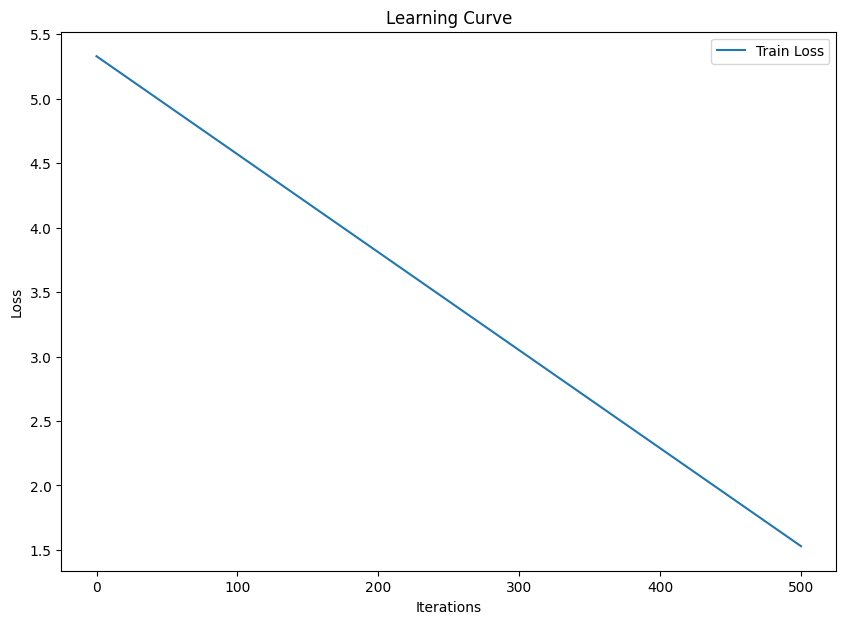

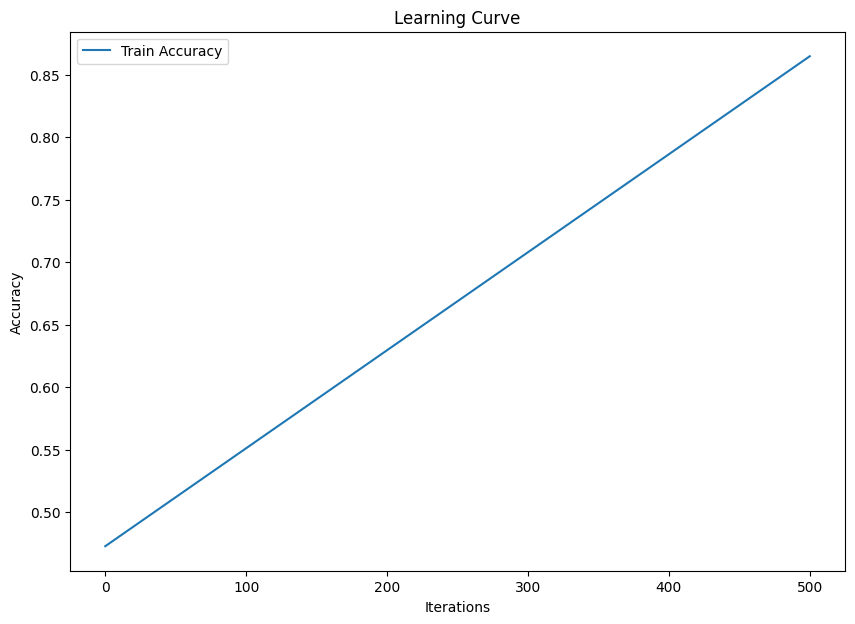

In [ ]:
#learning curve
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, iterations, 500), trainloss, label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, iterations, 500), trainaccc, label='Train Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

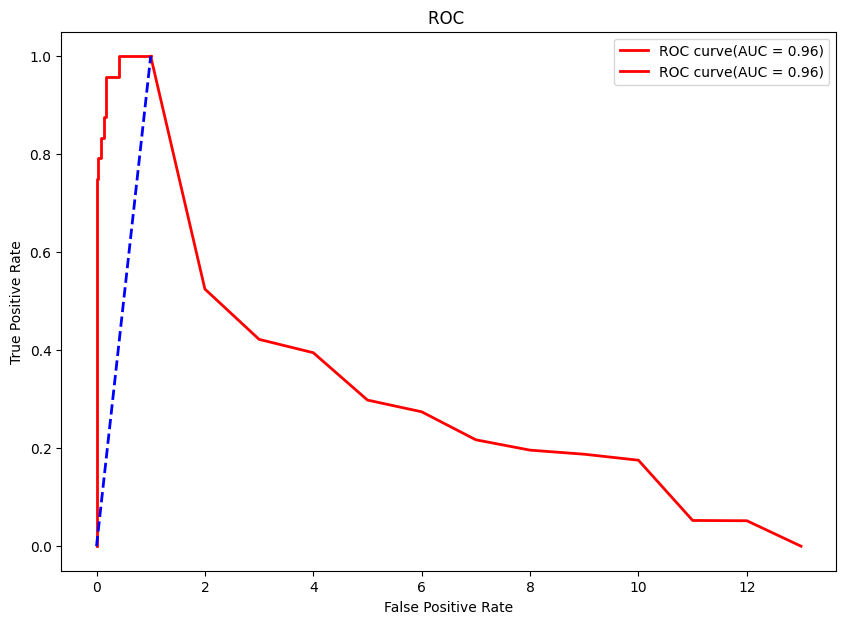

In [ ]:
#roc

plt.figure(figsize=(10, 7))
fpr, tpr, thr = roc_curve(y_test.to_numpy(), test_pred)
plt.plot(fpr, tpr, thr, color='red', lw=2, label=f'ROC curve(AUC = {auc(fpr,tpr):.2f})')
plt.plot([0,1], [0,1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC ')
plt.legend()
plt.show()

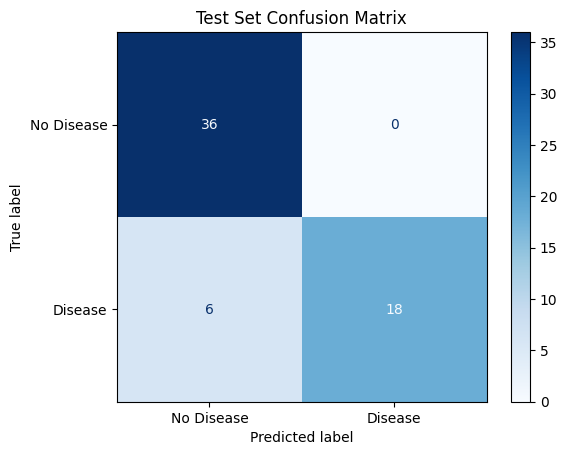

In [ ]:
conf = confusion_matrix(y_test, test_predictions)
cmplt = ConfusionMatrixDisplay(conf, display_labels=['No Disease', 'Disease'])
cmplt.plot(cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.grid(False)
plt.show()

In [ ]:
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 0.7500
F1 Score: 0.8571
